In [1]:
# Custom Imports
import polysaccharide as ps
from polysaccharide import analysis, extratypes, filetree, general, logutils, molutils
from polysaccharide import representation as rep

from polysaccharide import charging
from polysaccharide.charging.types import AtomIDMap, ResidueChargeMap
from polysaccharide.charging.residues import ChargedResidue
from polysaccharide.charging.application import CHARGER_REGISTRY, ChargingParameters

from polysaccharide import LOGGERS_MASTER
from polysaccharide.logutils import ProcessLogHandler
from polysaccharide.molutils.rdmol import rdkdraw
from polysaccharide.representation import Polymer, PolymerManager, has_sims
from polysaccharide.solvation.solvents import WATER_TIP3P
from polysaccharide.analysis import trajectory, statistics
from polysaccharide.simulation.records import SimulationPaths, SimulationParameters
from polysaccharide.graphics import plotutils

# Generic Imports
import re
from functools import partial
from collections import defaultdict
from itertools import combinations

# Numeric imports
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# File I/O
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree
import importlib.resources as impres

# Logging and Shell
import logging
logging.basicConfig(level=logging.INFO)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.interchange import Interchange
from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openff.units import unit
from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# polymer resource management
import importlib_resources as impres
import resources
RESOURCE_PATH = impres.files(resources)

# Static Paths
COLL_PATH = Path('Collections')
COMPAT_PDB_PATH = Path('compatible_pdbs_updated')

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


## Loading Polymer Manager

In [2]:
reset      = False 
purge_sims = False  
purge_logs = False 
solvate    = False

# poly_source_path = COMPAT_PDB_PATH / 'simple_polymers'
# poly_source_path = COMPAT_PDB_PATH / 'water_soluble_polymers'
# poly_source_path = COMPAT_PDB_PATH / 'water_soluble_reduced'
# poly_source_path = COMPAT_PDB_PATH / 'water_soluble_small_conf'
poly_source_path = COMPAT_PDB_PATH / 'water_soluble_large'
# poly_source_path = COMPAT_PDB_PATH / 'water_soluble_large_conf'
solv_template    = RESOURCE_PATH/'inp_templates'/'solv_polymer_template_box.inp'
desired_solvents = (WATER_TIP3P,) # (None,)
exclusion = 1.0*nanometer

# Define derived paths and create manager
collection_path  = COLL_PATH / poly_source_path.name
structure_path   = poly_source_path / f'{poly_source_path.name}_structures'
monomer_path     = poly_source_path / f'{poly_source_path.name}_monomers'

mgr = PolymerManager(collection_path)

# Perform manager setup / purge actions
if purge_logs: # NOTE : must be done BEFORE log FileHandler is created, as this will destroy it's output as well
    mgr.purge_logs(really=True)

creation_logger = logging.getLogger('polymer_setup')
loggers = [creation_logger, *LOGGERS_MASTER]

with ProcessLogHandler(filedir=mgr.log_dir, loggers=loggers, proc_name=f'Setup of {mgr.collection_dir.name}', timestamp=True):
    if reset:
        mgr.purge_collection(really=True, purge_logs=False) # Explicitly DON'T purge logs here (will be done prior to entering log loop)

    if purge_sims:
        mgr.purge_sims(really=True)

    if not mgr.polymers: # will be empty if not yet instantiated or if reset prior
        mgr.populate_collection(struct_dir=structure_path, monomer_dir=monomer_path)
        if solvate:
            mgr.solvate_collection(desired_solvents, template_path=solv_template, exclusion=exclusion)

## Experimenting with grid size optimization WRT aspect and number of squares

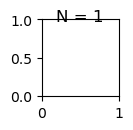

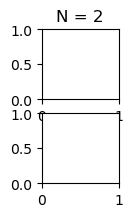

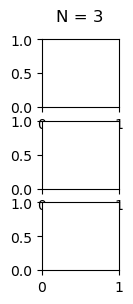

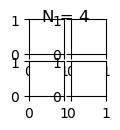

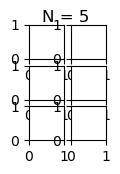

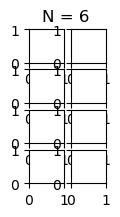

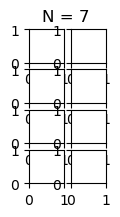

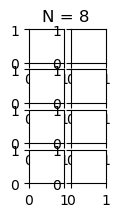

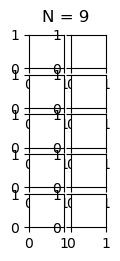

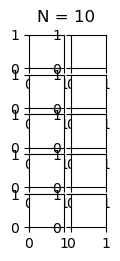

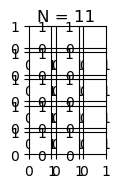

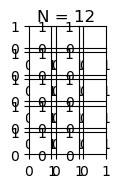

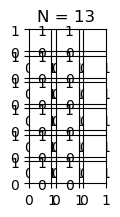

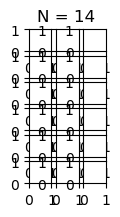

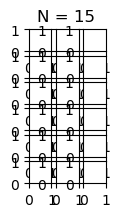

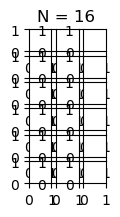

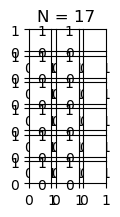

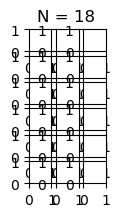

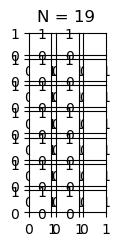

In [139]:
from math import ceil, sqrt, floor

def size_penalty(N_targ : int, N_real : int) -> float:
    return (N_real / N_targ - 1)**2

def aspect_penalty(a_targ : float, a_real : float) -> float:
    # return (a_real / a_targ - 1)**2
    return 1 - min(a_targ / a_real, a_real / a_targ)

def dims(N : int, a : float=1/1, w1=1, w2=1) -> tuple[int, int]:
    '''Given a particular number of cells and an aspect ratio, yields the smallest 2x2 grid dimensions which accomodate at least N grid squares whose aspect ratio is closest to the '''
    return min( 
        ((r, ceil(N / r))
            for r in range(1, N + 1)
        ),
        key=lambda dims : w1*size_penalty(N, dims[0]*dims[1]) + w2*aspect_penalty(a, dims[0]/dims[1])
    )

a = 2/1
for N in range(1, 20):
    nrows, ncols = dims(N, a)
    fig, ax = plotutils.presize_subplots(nrows=nrows, ncols=ncols, scale=1)
    fig.suptitle(f'N = {N}')

## Testing PyMBAR timeseries equilibration detection

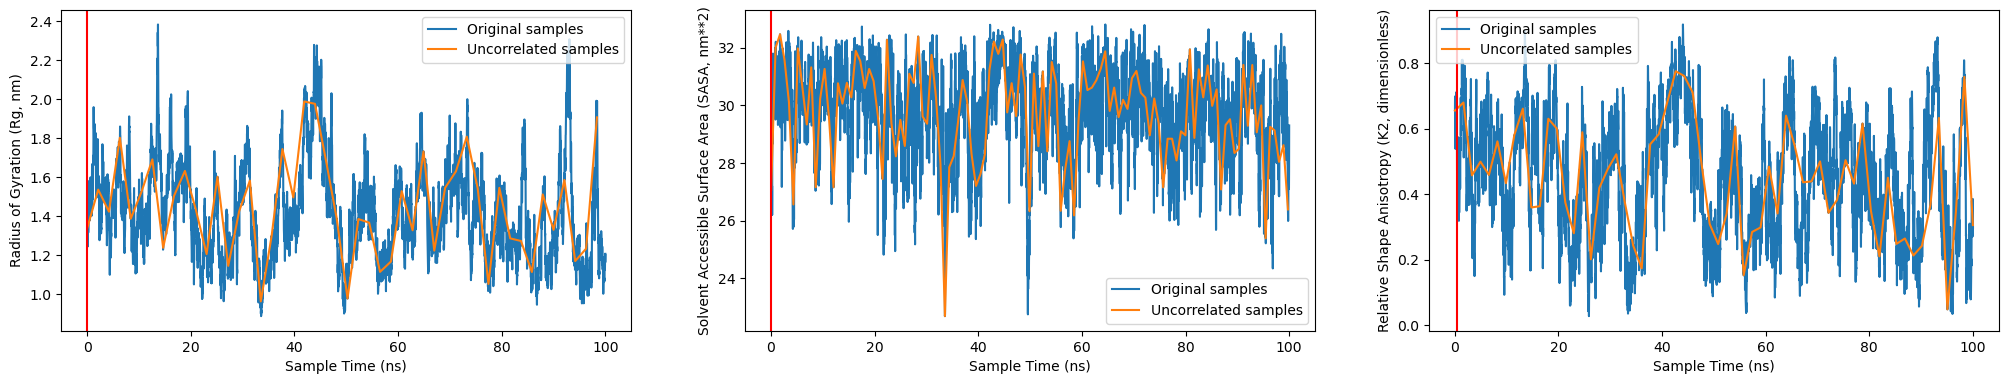

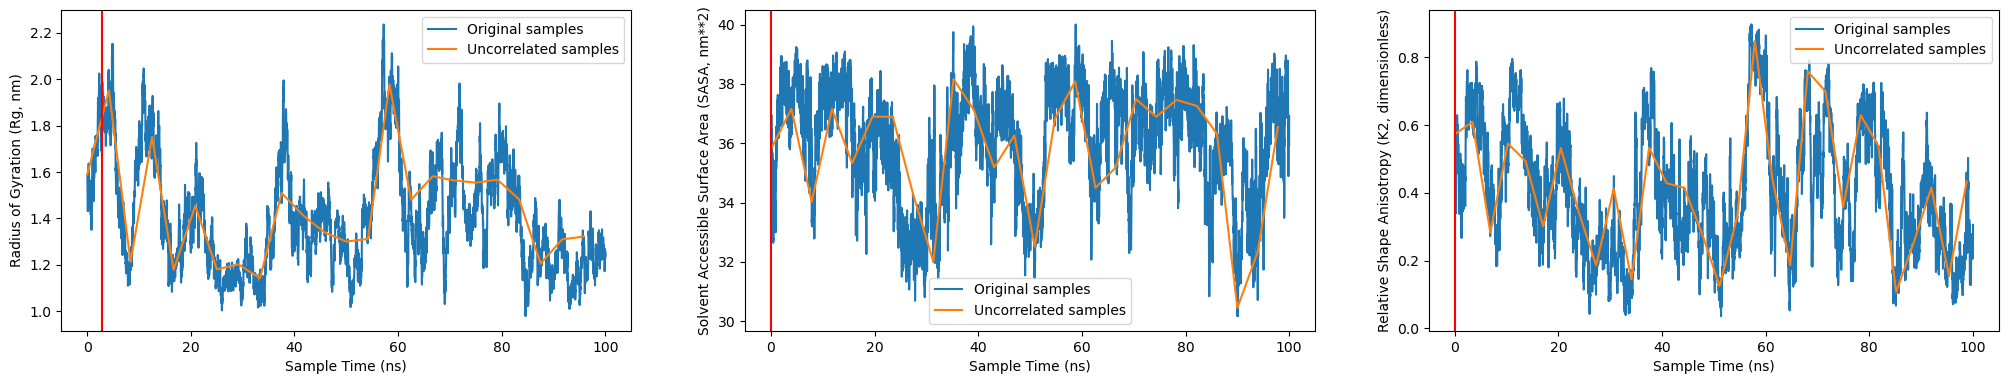

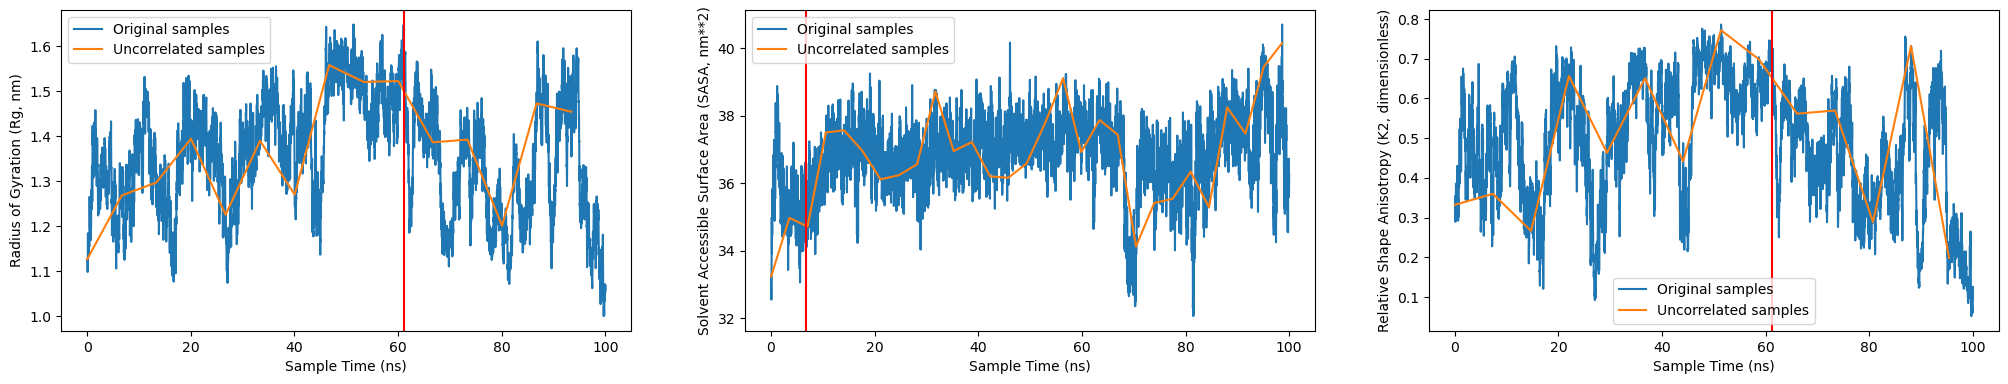

In [9]:
from pymbar import timeseries
from polysaccharide.analysis.equilibrium import EQUIL_DETECTOR_REGISTRY
equil_det = EQUIL_DETECTOR_REGISTRY['PyMBAREquilDetector']
# equil_det = EQUIL_DETECTOR_REGISTRY['BinSegEquilDetector']

fast = True

outdir = Path('figures_for_paper/pymbar_equil')
outdir.mkdir(exist_ok=True)

for mol_name, pdir in mgr.filtered_by(rep.is_solvated).items():
    mol_dir = outdir/mol_name
    mol_dir.mkdir(exist_ok=True)

    sim_paths, sim_params = pdir.load_sim_paths_and_params()
    time_df = pd.read_csv(sim_paths.time_data)
    times, time_data = trajectory.props_to_plot_data(time_df)
    times_arr = times.to_numpy()[:, 0]

    fig, ax = plotutils.plot_df_props(times, time_data, df_label='Original samples', elongation=1/2, scale=25)
    for axes, (label, prop_data) in zip(ax.flatten(), time_data.items()):
        prop_data = prop_data.to_numpy()
        t = equil_det.equil_loc(prop_data)
        uncorr_idxs = timeseries.subsample_correlated_data(prop_data, fast=fast)
        t_equil = times_arr[t]

        axes.plot(times_arr[uncorr_idxs], prop_data[uncorr_idxs], label='Uncorrelated samples')
        axes.axvline(t_equil, color='r')
        axes.legend()

    # fig.savefig(mol_dir/f'pymbar_props_{mol_name}.png', bbox_inches='tight')
    # plt.close()

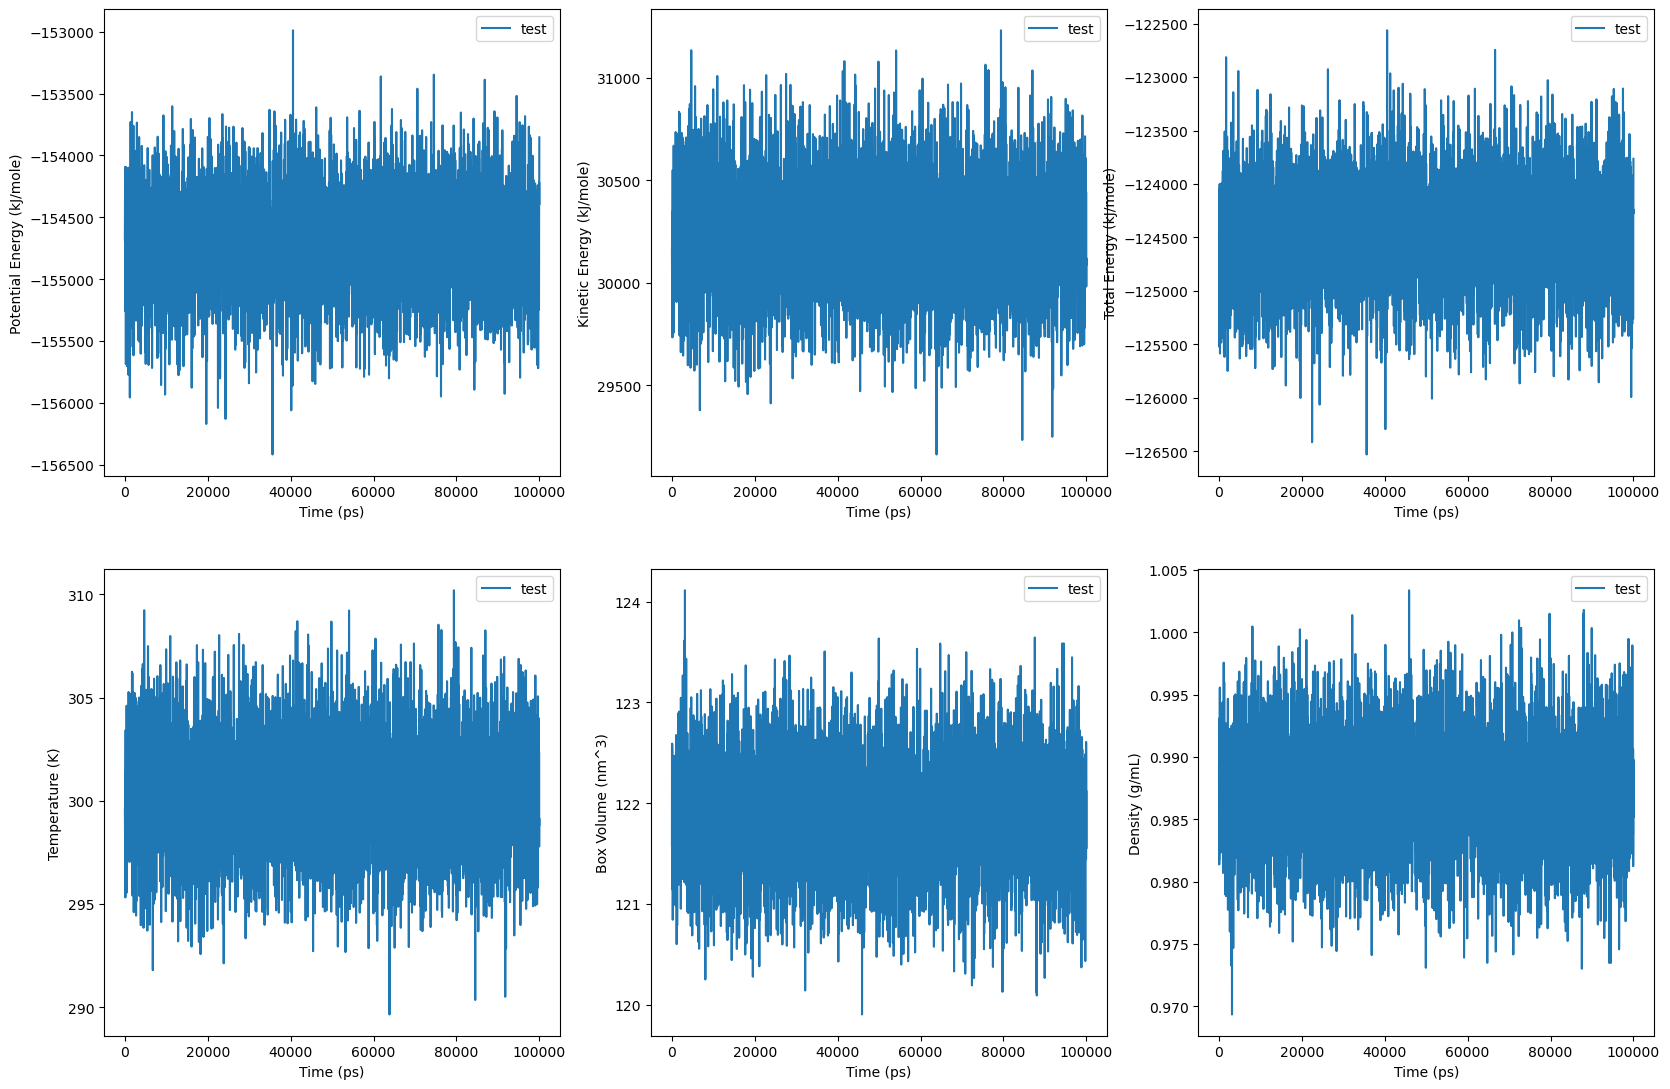

In [15]:
pdir = mgr.polymers['peg_modified_solv_water']

sim_paths, sim_params = pdir.load_sim_paths_and_params()
state_df = pd.read_csv(sim_paths.state_data)

exclude = ('#"Step"', 'Elapsed Time (s)', 'Speed (ns/day)')
state_df = state_df[[label for label in state_df.columns if label not in exclude]]
state_time, state_data = trajectory.props_to_plot_data(state_df)

fig, ax = plotutils.plot_df_props(state_time, state_data, df_label='test', nrows=2, ncols=3, scale=20)
for axes in ax.flatten():
    axes.legend()

In [ ]:
from openff.toolkit.utils._nagl_wrapper import _NAGLToolkitWrapper

wrap = _NAGLToolkitWrapper()
wrap.toolkit_name

## Plotting disparities in charges

In [ ]:
num_bins = 30
order = ['ABE10_exact', 'ABE10_averaged', 'Espaloma_AM1BCC']
outdir = Path('figures_for_paper') / f'Charge diagrams - {mgr.collection_dir.stem}'
outdir.mkdir(exist_ok=True)

for mol_name, polymer in mgr.filtered_by((rep.is_unsolvated, rep.is_charged)).items():
    savedir = outdir / mol_name
    savedir.mkdir(exist_ok=True)

    # single charges
    for charge_method in polymer.charges: 
        polymer.assign_charges_by_lookup(charge_method)
        fig, ax = molutils.rdmol.rdkdraw.rdmol_prop_heatmap_colorscaled(
            polymer.offmol.to_rdkit(),
            prop='PartialCharge',
            annotate=True,
            cmap=plt.get_cmap('viridis'),
            cbar_label=f'q (elem. charge) ({charge_method} only)'
        )
        fig.savefig(savedir/f'{mol_name} charges - {charge_method}', bbox_inches='tight')
        plt.close()

    # charge pairs
    for (chg_method_1, chg_method_2) in combinations(sorted(polymer.charges.keys(), key=lambda x : order.index(x)), 2):
        chg_str = f'{chg_method_1} vs {chg_method_2}'
        chgs_ref  = polymer.charges[chg_method_1]._magnitude
        chgs_comp = polymer.charges[chg_method_2]._magnitude
        diff = chgs_ref - chgs_comp
        chg_RMSE = round(analysis.statistics.RMSE(chgs_ref, chgs_comp), 4)

        fig, ax = polymer.compare_charges(chg_method_1, chg_method_2, annotate=True, converter='CXSMARTS')
        fig.savefig(savedir/f'{mol_name} charge comparison - {chg_str}', bbox_inches='tight')
        plt.close()

        # pair histograms
        plt.hist(diff, bins=np.linspace(diff.min(), diff.max(), num_bins))
        plt.xlabel(f'{general.GREEK_UPPER["delta"]}q (elem. charge): {chg_str}')
        plt.ylabel('Number of atoms')
        plt.legend([f'RMSE = {chg_RMSE} e'], loc='best')
        plt.savefig(savedir/f'{mol_name} histogram - {chg_str}', bbox_inches='tight')
        plt.close()

## Testing Fragmented RCT procedure

In [ ]:
import copy

# mol_name = 'naturalrubber_solv_water' 
mol_name = 'pnipam_modified_solv_water' 

pdir = mgr.polymers[mol_name]
offmol = pdir.offmol
rdmol = offmol.to_rdkit()
# offmol = pdir.offmol_matched(strict=False, verbose=False)
# rdmol = pdir.rdmol

# Labelled all unmatched atoms
for i, atom in enumerate(offmol.atoms):
    rdatom = rdmol.GetAtomWithIdx(i)
    # rdatom.SetProp('atomNote', atom.metadata.get('residue_name', 'unmatched'))
print('Matched residues : ', set(atom.metadata.get('residue_name') for atom in offmol.atoms))

rdkdraw.set_rdkdraw_size(800, 1/1)
rdmol

In [ ]:
# show individual constituent monomers
from rdkit.Chem.Draw import MolsToGridImage
import polysaccharide.molutils.fragment as frag 

offmol = pdir.offmol_matched()
rdmol  = offmol.to_rdkit()
mono_frags = frag.monomer_frags_with_residues(offmol, hydrogenate_ports=True)

n = 800
rdkdraw.set_rdkdraw_size(n, 1/1)
MolsToGridImage(mono_frags.keys(), molsPerRow=6, subImgSize=(n, n), legends=mono_frags.values())

In [ ]:
sm = [
    Molecule.from_rdkit(mono_frag, allow_undefined_stereo=True, hydrogens_are_explicit=True)
        for mono_frag in mono_frags
]

In [ ]:
single = set(sm).pop()
charging.application.generate_molecule_charges(single, force_match=False)
print(single.partial_charges, pdir.monomer_data_charged['charges'])

## Testing Polymer building and from-monomer calculations

In [ ]:
from polysaccharide.molutils.polymer import abmono, building

for pdir in mgr.polymers_list:
    if pdir.has_monomer_data:
        mono = pdir.monomer_data['monomers']
        print(pdir.mol_name, abmono.count_middle_and_term_mono(mono), '\n\tLinear : ', abmono.is_linear(mono), '\n\tHomo : ', abmono.is_homopolymer(mono))

In [ ]:
from collections import defaultdict

solvent = None
DOP_min, DOP_max = 3, 10

# testing that chain length errors (if any) are independent of DOP
res = []
logs = defaultdict(list)
for i, polymer in enumerate(mgr.polymers_list):
    if polymer.solvent == solvent:
        print(polymer.mol_name)
        try:
            mono_structs = polymer.monomer_data['monomers']
            if polymer.mol_name == 'paam_modified':
                mono_structs.pop('paam_SPECIAL_TERM')

            print(f'{len(mono_structs)} monomers in chain')

            dop_errors = []
            for DOP in range(DOP_min, DOP_max):
                n_atoms_pred = abmono.estimate_chain_len(mono_structs, DOP=DOP)
                chain = building.build_linear_polymer(mono_structs, DOP=DOP, add_Hs=False)
                n_atoms_real = chain.n_particles
                print(n_atoms_real, n_atoms_pred)
                dop_errors.append(n_atoms_real - n_atoms_pred)
            res.append(dop_errors)
            logs['Success'].append(polymer.mol_name)

        except Exception as e:
            print(e)
            logs[type(e).__name__].append(polymer.mol_name)

res = np.array(res)            
plt.imshow(res)

In [ ]:
# demonstrating RDKit aromaticity substructure mismatch for even simple ringed molecules (e.g. benzene)
rdkdraw.set_rdkdraw_size(300, 2/1)
smiles_mol = Chem.MolFromSmiles('C1-C=C-C=C-C=1')
# smiles_mol = Chem.AddHs(smiles_mol)
Chem.MolToSmarts(smiles_mol)

smarts_mol = Chem.MolFromSmarts('[#6]1-[#6]=[#6]-[#6]=[#6]-[#6]=1')
# smarts_mol = Chem.AddHs(smarts_mol)
display(smiles_mol)
display(smarts_mol)
smarts_mol.GetSubstructMatch(smiles_mol)

## Comparing converters for heatmapping drawing

In [ ]:
cmap = plt.get_cmap('turbo')
# pdir = mgr.polymers['polythiophene_solv_water']
pdir = mgr.polymers['polyethylmethacrylate_solv_water']

dim = 10
aspect = 4/1
annotate = False

for cvtr_type in ('InChI', 'SMARTS', 'CXSMARTS'):
    fig, ax = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap, annotate=annotate, precision=5, converter=cvtr_type)
    fig.set_size_inches(dim, dim * aspect)

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps

cvtr = 'InChI'

offmol1 = pdir.charged_offmol_from_sdf('ABE10_exact')
rdmol1 = offmol1.to_rdkit()
flatmol1 = rdconvert.flattened_rdmol(rdmol1, converter=cvtr)

offmol2 = pdir.charged_offmol_from_sdf('Espaloma_AM1BCC')
rdmol2 = offmol2.to_rdkit()
flatmol2 = rdconvert.flattened_rdmol(rdmol2, converter=cvtr)

diff = rdcompare.difference_rdmol(flatmol1, flatmol2, prop='PartialCharge', remove_map_nums=True)
deltas = [diff.GetAtomWithIdx(i).GetDoubleProp('DeltaPartialCharge') for i in range(diff.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(diff, deltas, colorMap='jet', contourLines=10, alpha=0.3)
plt.savefig('test.png')

In [ ]:
# PIL.Image.frombytes('RGBA', fig.canvas.get_width_height(), fig.canvas.tostring_argb())

n = 250
img = PIL.Image.frombytes('RGB', (n, n), fig.canvas.tostring_rgb())
display(img)

In [ ]:
pdir = mgr.polymers['polyvinylchloride_solv_water']

fig1, ax1 = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap=plt.get_cmap('turbo'), converter='InChI')
fig2, ax2 = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap=plt.get_cmap('turbo'), converter='SMARTS')

ax1.set_title(pdir.mol_name)
ax2.set_title(pdir.mol_name)

## Generating monomer files for polyamides

In [ ]:
POLYAM_PATH   = Path('compatible_pdbs/polyamides')
p = POLYAM_PATH/'smiles.json'

with p.open('r') as smiles_file:
    mono_smiles = json.load(smiles_file)
mono_smiles['TMC'] = mono_smiles['TMC'].replace('Cl', 'O[H]') # replace chlorides with oxygens present in full polymer

rdkdraw.set_rddraw_size(400, 3/2)

mono_mols, mono_smarts = {}, {}
for name, SMILES in mono_smiles.items():
    rdmol = Chem.MolFromSmiles(SMILES, sanitize=False)
    for atom in rdmol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx() + 1)
    
    mono_mols[name] = rdmol
    mono_smarts[name] = Chem.MolToSmarts(rdmol)

    display(rdmol)


In [ ]:
monomers = {
    'MPD_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-[H:14]):[#6:15]:1-[H:16]',
    'MPD_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-*):[#6:15]:1-[H:16]',
    'TMC_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-[#8:13]-[H:14]):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_trivalent'  : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-*', 
}

json_spec = {
    'monomers' : monomers,
    'caps' : {name : [] for name in monomers}
}

pam_mono_path = POLYAM_PATH/'polyamides.json'
with pam_mono_path.open('w') as mono_out:
    json.dump(json_spec, mono_out, indent=4)

for pam_path in POLYAM_PATH.glob('*.pdb'):
    ind_mono_path = POLYAM_PATH/f'{pam_path.stem}.json'
    with ind_mono_path.open('w') as mono_out:
        json.dump(json_spec, mono_out, indent=4)

## Testing loading of polyamides using monomer spec

In [ ]:
pam_pdbs = [path for path in POLYAM_PATH.glob('*.pdb')]

In [ ]:
pdb_file = pam_pdbs[1]

openff_topology, _, _error = Topology.from_pdb_and_monomer_info(str(pdb_file), pam_mono_path, strict=False, verbose=False)
mol = next(openff_topology.molecules)

for atom in mol.atoms:
    if not atom.metadata['already_matched']:
        print(atom.metadata)

rdkdraw.set_rddraw_size(500, 3/2)
display(mono_mols[pdb_file.stem])

## Some other section